In [177]:
from __future__ import division
from scipy import integrate
import matplotlib.pyplot as plt
import numpy as np
import emcee
import corner
%matplotlib inline

### Problem 1 

In [18]:
import kplr
client = kplr.API()
koi = client.koi(97.01)
lcs = koi.get_light_curves(short_cadence=False)
f = lcs[0].open()
hdu_data = f[1].data
time = hdu_data["time"]
flux = hdu_data["sap_flux"]
flux_err = hdu_data["sap_flux_err"]
f.close()

In [19]:
# obtain indices of light-curve points within specified time window
indices = np.where((time >= 124)&(time <= 125))

In [20]:
# assign flux, time, and uncertainty values associated obtained indices
time125 = time[indices[0][0]:indices[0][-1]]
flux125 = flux[indices[0][0]:indices[0][-1]]
sig125 = flux_err[indices[0][0]:indices[0][-1]]

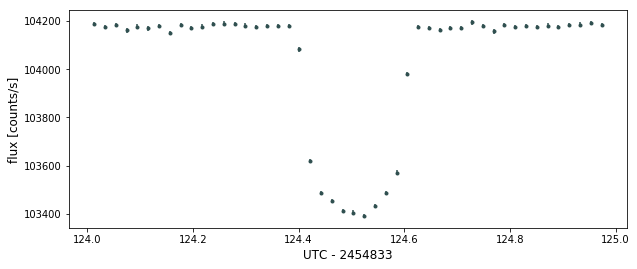

In [21]:
# plot the light-curve (for visualization purposes)
plt.figure(figsize=(10,4))
plt.errorbar(time125, flux125, sig125, color='darkslategrey', marker='.', ls='None')
plt.xlabel('UTC - 2454833', fontsize=12)
plt.ylabel('flux [counts/s]', fontsize=12)
plt.show()

In [22]:
# function to normalize stellar flux
def normstar(flux):
    """ returns the mean unobscured stellar flux, excluding the transit; 
        transit is excluded by calculating the mean and standard deviation
        of the light curve and removing the points which lie more than 2sigma 
        away from the mean"""
    fvals = []
    Fbar = np.mean(flux)
    sigma = np.std(flux)
    for f in flux:
        if abs(f - Fbar)/sigma > 2.0:
            continue
        else:
            fvals.append(f)
    
    return np.mean(fvals), fvals

In [23]:
# calculating the mean unobscured stellar flux and normalize light-curve
flux4mean = flux125
for i in range(5):
    meanflux, flux4mean = normstar(flux4mean)

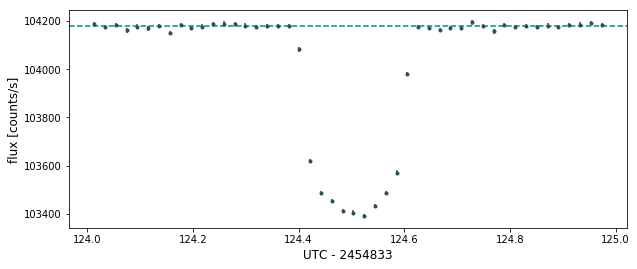

In [24]:
# plot the light-curve with mean stellar flux
plt.figure(figsize=(10,4))
plt.errorbar(time125, flux125, sig125, color='darkslategrey', marker='.', ls='None')
plt.axhline(y=meanflux, color='darkcyan', ls='--')
plt.xlabel('UTC - 2454833', fontsize=12)
plt.ylabel('flux [counts/s]', fontsize=12)
plt.show()

In [25]:
# normalize light-curve and uncertainties
flux_norm = flux125/meanflux
sig_norm = sig125/meanflux

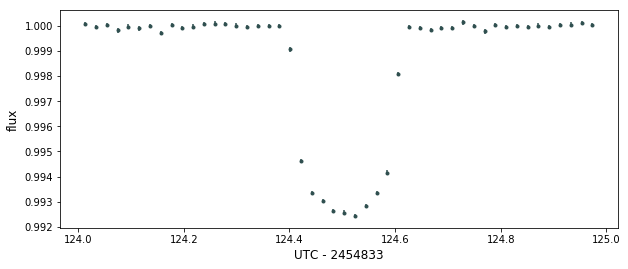

In [26]:
# plot the normalized light-curve
plt.figure(figsize=(10,4))
plt.errorbar(time125, flux_norm, sig_norm, color='darkslategrey', marker='.', ls='None')
plt.xlabel('UTC - 2454833', fontsize=12)
plt.ylabel('flux', fontsize=12)
plt.show()

##### limb-darkening relation: $I(r) = 1-(1-\mu^{1/2})$; where $\mu = (1-r^2)^{1/2}$

In [27]:
# define limb-darkening function
def I_r(r):
    mu = np.sqrt(1 - r**2)
    return 1 - (1 - np.sqrt(mu))

In [28]:
# guesses for parameters and conversion of time to 'z'
p = 0.0775
tau = 0.1
t0 = 124.51

z_vals = (time125 - t0) / tau

In [29]:
# define 'del' function for flux ratio calculation
def delta(r, p, z):
    z = abs(z)
    if (z+p <= r) or (r <= z-p):
        d = 0
    elif r+z <= p:
        d = 1
    else:
        if (z != 0) and (r != 0):
            d = (1/np.pi) * np.arccos((z**2 - p**2 + r**2) / (2*z*r))
        else:
            print "WARNING! Either 'r' or 'z' have vanished; cannot divide by zero!"
    return d

In [30]:
numerator = lambda r: I_r(r) * (1 - delta(r, p, z)) * 2*r
denominator = lambda r: I_r(r) * 2*r

In [51]:
# using scipy integrate to ...
bottom_test = []
f_vals = np.zeros(len(z_vals))
for i in range(len(z_vals)):
    z = z_vals[i]
    top = integrate.quad(numerator, 0, 1)
    bottom = integrate.quad(denominator, 0, 1)
    bottom_test.append(bottom[0])
    f_vals[i] = top[0]/bottom[0]

In [32]:
# define chi-squared function
def chi2(f_model, f_obs, sig_obs):
    """ returns the chi-squared value  """
    return sum(((f_obs - f_model)/sig_obs)**2)

In [33]:
# calculate the chi-squared value for the fitted limb-darkening model
X2 = chi2(f_vals, flux_norm, sig_norm)

In [34]:
# print calculated chi-squared value
print u'\u03C7\u00B2=', X2

χ²= 464.862918399


### Problem 2

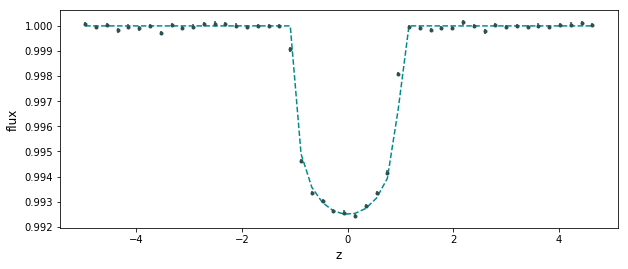

In [35]:
# plot the normalized light-curve with the fitted limb-darkening model
plt.figure(figsize=(10,4))
plt.errorbar(z_vals, flux_norm, sig_norm, color='darkslategrey', marker='.', ls='None')
plt.plot(z_vals, f_vals, color='darkcyan', ls='--')
plt.xlabel('z', fontsize=12)
plt.ylabel('flux', fontsize=12)
plt.show()

#### Bye 'eye', this appears to be a good fit

In [36]:
N = len(z_vals)
M = 3
nu = N-M

a = nu/2
x = X2/2

In [37]:
gamma = lambda t: np.exp(-t) * t**(a-1)

In [38]:
top = integrate.quad(gamma, x, np.inf)
bottom = integrate.quad(gamma, 0, np.inf)

Q = top[0] / bottom[0]

In [39]:
print "Q =", Q

Q = 3.94910224032e-71


Very small Q; meaning the fitted model is probably wrong...
Not a good fit

### Problem 3

In [142]:
start = 0.08
finish = 0.13
ds = 0.0010
cf = 1/ds
tau_vals = np.arange(start*cf, (finish+ds)*cf, ds*cf)/cf

In [143]:
chi2_vals = []
for tau_val in tau_vals:
    z_vals = (time125 - t0) / tau_val
    f_vals = np.zeros(len(z_vals))
    for i in range(len(z_vals)):
        z = z_vals[i]
        top = integrate.quad(numerator, 0, 1)
        bottom = integrate.quad(denominator, 0, 1)
        f_vals[i] = top[0]/bottom[0]
    X2 = chi2(f_vals, flux_norm, sig_norm)
    chi2_vals.append(X2)

In [144]:
# find index for minimum chi-squared value
chi2_min = np.argmin(chi2_vals)

In [145]:
print chi2_vals[chi2_min]
print tau_vals[chi2_min]

247.868901725
0.097


In [146]:
# exploring new tau-value
new_tau = tau_vals[chi2_min]
new_zvals = (time125 - t0) / new_tau

new_fvals = np.zeros(len(new_zvals))
for i in range(len(new_zvals)):
    z = new_zvals[i]
    top = integrate.quad(numerator, 0, 1)
    bottom = integrate.quad(denominator, 0, 1)
    new_fvals[i] = top[0]/bottom[0]

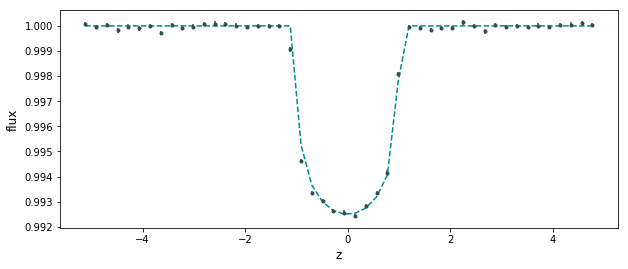

In [147]:
# plot the normalized light-curve with the fitted limb-darkening model
plt.figure(figsize=(10,4))
plt.errorbar(new_zvals, flux_norm, sig_norm, color='darkslategrey', marker='.', ls='None')
plt.plot(new_zvals, new_fvals, color='darkcyan', ls='--')
plt.xlabel('z', fontsize=12)
plt.ylabel('flux', fontsize=12)
plt.show()

In [148]:
N = len(z_vals)
M = 3
nu = N-M

a = nu/2
x = chi2_vals[chi2_min]/2

In [164]:
print chi2_vals[chi2_min]

247.72302829


In [149]:
top = integrate.quad(gamma, x, np.inf)
bottom = integrate.quad(gamma, 0, np.inf)

Q = top[0] / bottom[0]

In [150]:
print "Q =", Q

Q = 7.66249916787e-30


Still a pretty crappy p-value...

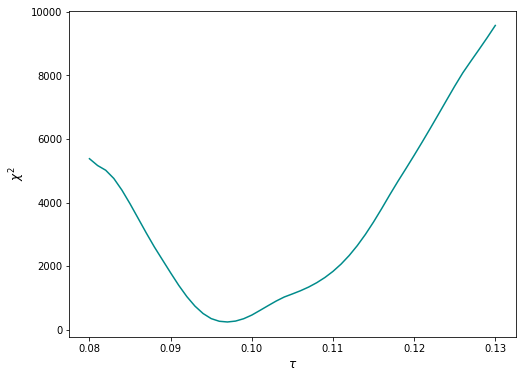

In [151]:
plt.figure(figsize=(8,6))
plt.plot(tau_vals, chi2_vals, color='darkcyan', ls='-')
plt.xlabel(r'$\tau$', fontsize=12)
plt.ylabel(r'$\chi^2$', fontsize=12)
plt.show()

#### Zoom in on $\tau$ range for finer calculations

In [152]:
start = 0.09670
finish = 0.09715
ds = 0.00001
cf = 1/ds
tau_vals = np.arange(start*cf, (finish+ds)*cf, ds*cf)/cf

In [153]:
chi2_vals = []
for tau_val in tau_vals:
    z_vals = (time125 - t0) / tau_val
    f_vals = np.zeros(len(z_vals))
    for i in range(len(z_vals)):
        z = z_vals[i]
        top = integrate.quad(numerator, 0, 1)
        bottom = integrate.quad(denominator, 0, 1)
        f_vals[i] = top[0]/bottom[0]
    X2 = chi2(f_vals, flux_norm, sig_norm)
    chi2_vals.append(X2)

In [154]:
# find index for minimum chi-squared value
chi2_min = np.argmin(chi2_vals)

In [155]:
cs = np.polyfit(tau_vals, chi2_vals, 4)
chi2_out = lambda x: cs[0]*x**4 + cs[1]*x**3 + cs[2]*x**2 + cs[3]*x + cs[4]

taus = np.arange(start*cf, finish*cf, ds*cf)/cf
chis = chi2_out(taus)

In [156]:
h = lambda x: chi2_out(x) - (chi2_vals[chi2_min]+1)

In [157]:
import scipy.optimize

In [158]:
x_int1 = scipy.optimize.fsolve(h, 0.0967)
x_int2 = scipy.optimize.fsolve(h, 0.0970)

In [166]:
print x_int1, x_int2

[ 0.09672547] [ 0.09712338]


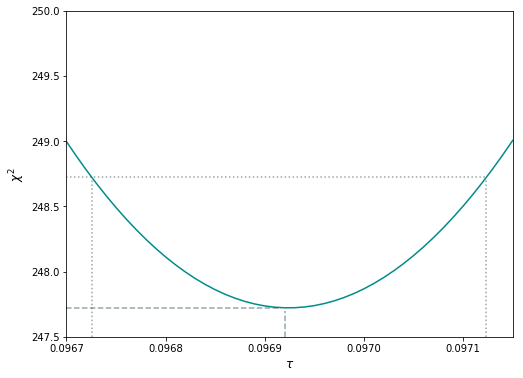

In [161]:
plt.figure(figsize=(8,6))
#plt.plot(tau_vals, chi2_vals, color='darkcyan', ls='-')
plt.plot(taus, chis, color='darkcyan', ls='-')
plt.axvline(x=tau_vals[chi2_min], ymax=0.08, color='darkslategrey', ls='--', alpha=0.5)
plt.axhline(y=chi2_vals[chi2_min]+1, xmax=0.94, color='darkslategrey', ls=':', alpha=0.5)
plt.axhline(y=chi2_vals[chi2_min], xmax=0.48, color='darkslategrey', ls='--', alpha=0.5)
plt.axvline(x=x_int1, ymax=0.48, color='darkslategrey', ls=':', alpha=0.5)
plt.axvline(x=x_int2, ymax=0.48, color='darkslategrey', ls=':', alpha=0.5)
plt.xlim([0.09670, 0.09715])
plt.ylim([247.5, 250])
plt.xlabel(r'$\tau$', fontsize=12)
plt.ylabel(r'$\chi^2$', fontsize=12)
plt.show()

In [175]:
print tau_vals[chi2_min]

0.09692


### Problem 4

In [10]:
def lnprior(p, tau, t0):
    """ Return the log prior given parameter vector 'x' """
    p, tau, t0 = x
    if p < 0.05 or p > 0.15:
        return -np.inf
    elif tau < 0.08 or tau > 0.13:
        return -np.inf
    elif t0 < 124.4 or tau > 124.6:
        return -np.inf
    else:
        return 0

In [167]:
def lnlike(p, tau, t0, data, funs):
    time = data[0]
    flux = data[1]
    sig = data[2]
    
    ll = lnprior(p, tau, t0)
    if np.isinf(ll):
        return ll, (np.nan, np.nan)
    
    z_vals = (time - t0)/tau
    f_vals = np.zeros(len(z_vals))
    for i in range(len(z_vals)):
        z = z_vals[i]
        top = integrate.quad(fun[0], 0, 1)
        bottom = integrate.quad(fun[1], 0, 1)
        f_vals[i] = top[0]/bottom[0]
    ll += chi2(f_vals, flux, sig)
    
    return ll

In [182]:
data = [time125, flux_norm, sig_norm]
funs = [numerator, denominator]

In [187]:
starters = [0.0775, 0.097, 124.51] + 1e-4*np.random.randn(32, 3)
nwalkers, ndim = starters.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike, args=(data[0], data[1], data[2]))
test = sampler.run_mcmc(starters, 5000)

emcee: Exception while calling your likelihood function:
  params: [  7.75639188e-02   9.68621483e-02   1.24510009e+02]
  args: (array([ 124.013216  ,  124.0336506 ,  124.054085  ,  124.0745195 ,
        124.094954  ,  124.1153885 ,  124.135823  ,  124.1562575 ,
        124.1766921 ,  124.1971265 ,  124.217561  ,  124.2379955 ,
        124.25843   ,  124.2788645 ,  124.299299  ,  124.31973359,
        124.34016799,  124.36060249,  124.38103699,  124.40147149,
        124.42190599,  124.44234049,  124.46277509,  124.48320949,
        124.50364398,  124.52407838,  124.54451298,  124.56494748,
        124.58538188,  124.60581648,  124.62625097,  124.64668547,
        124.66711987,  124.68755447,  124.70798897,  124.72842336,
        124.74885796,  124.76929246,  124.78972686,  124.81016135,
        124.83059595,  124.85103035,  124.87146485,  124.89189934,
        124.91233394,  124.93276834,  124.95320283,  124.97363743]), array([ 1.00006628,  0.99995989,  1.00003088,  0.9998188 ,  0.999

Traceback (most recent call last):
  File "C:\Anaconda2\lib\site-packages\emcee\ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)
TypeError: lnlike() takes exactly 5 arguments (4 given)


TypeError: lnlike() takes exactly 5 arguments (4 given)